# Interest Rate Term Structure

Term structure is pivotal to pricing securities. One would need a YieldTermStructure object created in QuantLib to use with pricing engines.

In [3]:
import QuantLib as ql

def print_curve(xlist, ylist, precision=3):
    """
    Method to print curve in a nice format
    """
    print("----------------------")
    print("Maturities\tCurve")
    print("----------------------")
    for x,y in zip(xlist, ylist):
        print(x,"\t\t", round(y, precision))
    print("----------------------")
    
    

The deposit rates and fixed rate bond rates are provided below. This example is based on Exhibit 5-5 given in Frank Fabozzi's Bond Markets, Analysis and Strategies, Sixth Edition.



In [4]:
# Deposit rates
depo_maturities = [ql.Period(6,ql.Months), ql.Period(12, ql.Months)]
depo_rates = [5.25, 5.5]

# Bond rates
bond_maturities = [ql.Period(6*i, ql.Months) for i in range(3,21)]
bond_rates = [5.75, 6.0, 6.25, 6.5, 6.75, 6.80, 7.00, 7.1, 7.15,
              7.2, 7.3, 7.35, 7.4, 7.5, 7.6, 7.6, 7.7, 7.8]

print_curve(depo_maturities+bond_maturities, depo_rates+bond_rates)

----------------------
Maturities	Curve
----------------------
6M 		 5.25
12M 		 5.5
18M 		 5.75
24M 		 6.0
30M 		 6.25
36M 		 6.5
42M 		 6.75
48M 		 6.8
54M 		 7.0
60M 		 7.1
66M 		 7.15
72M 		 7.2
78M 		 7.3
84M 		 7.35
90M 		 7.4
96M 		 7.5
102M 		 7.6
108M 		 7.6
114M 		 7.7
120M 		 7.8
----------------------


In [6]:
# some constants and conventions
# here we just assume for the sake of example
# that some of the constants are the same for
# depo rates and bond rates

calc_date = ql.Date(15, 1, 2015)
ql.Settings.instance().evaluationDate = calc_date

calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
bussiness_convention = ql.Unadjusted
day_count = ql.Thirty360(ql.Thirty360.BondBasis)
end_of_month = True
settlement_days = 0
face_amount = 100
coupon_frequency = ql.Period(ql.Semiannual)
settlement_days = 0

The basic idea of bootstrapping using QuantLib is to use the deposit rates and bond rates to create individual helpers. Then use the combination of the two helpers to construct the yield curve.

In [7]:
# create deposit rate helpers from depo_rates
depo_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r/100.0)),
                                     m,
                                     settlement_days,
                                     calendar,
                                     bussiness_convention,
                                     end_of_month,
                                     day_count )
                for r, m in zip(depo_rates, depo_maturities)]

The rest of the points are coupon bonds. We assume that the YTM given for the bonds are all par rates. So we have bonds with coupon rate same as the YTM.

In [8]:
# create fixed rate bond helpers from fixed rate bonds
bond_helpers = []
for r, m in zip(bond_rates, bond_maturities):
    termination_date = calc_date + m
    schedule = ql.Schedule(calc_date,
                   termination_date,
                   coupon_frequency,
                   calendar,
                   bussiness_convention,
                   bussiness_convention,
                   ql.DateGeneration.Backward,
                   end_of_month)

    helper = ql.FixedRateBondHelper(ql.QuoteHandle(ql.SimpleQuote(face_amount)),
                                        settlement_days,
                                        face_amount,
                                        schedule,
                                        [r/100.0],
                                        day_count,
                                        bussiness_convention,
                                        )
    bond_helpers.append(helper)

The yield curve is constructed by putting the two helpers together.

In [9]:
rate_helpers = depo_helpers + bond_helpers
yieldcurve = ql.PiecewiseLogCubicDiscount(calc_date,
                             rate_helpers,
                             day_count)

The spot rates is obtined from yieldcurve object using the zeroRate method.

In [10]:
# get spot rates
spots = []
tenors = []
compounding = ql.Compounded
freq = ql.Semiannual

for d in yieldcurve.dates():
    yrs = day_count.yearFraction(calc_date, d)
    zero_rate = yieldcurve.zeroRate(yrs, compounding, freq)
    tenors.append(yrs)
    eq_rate = zero_rate.equivalentRate(day_count, compounding, freq, calc_date, d).rate()
    spots.append(100 * eq_rate)

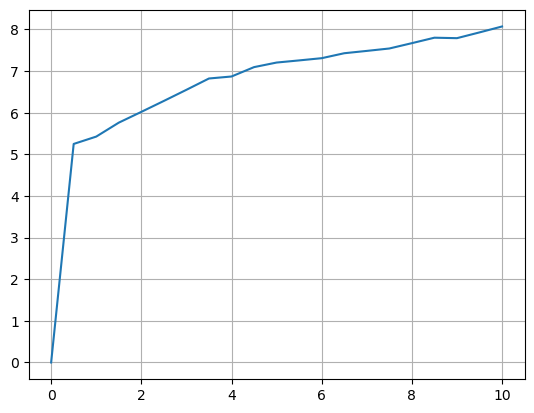

In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(tenors, spots)
ax.grid()
# plt.xticks(rotation = 45)